# YOLOv12-L Implementation for Military Aircraft Detection

This notebook implements YOLOv12-L for military aircraft detection using the [Military Aircraft Detection Dataset](https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset).

## Overview

YOLOv12 is an attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. It introduces a simple yet powerful "area attention" module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention.

In this notebook, we'll implement YOLOv12-L (large) for detecting military aircraft across 81 different classes.

## 1. Environment Setup

First, let's set up our environment by installing the necessary dependencies.

In [1]:
# Install YOLOv12 and other dependencies
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

# Check GPU availability
!nvidia-smi

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 58.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import os
import torch
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm import tqdm
from ultralytics import YOLO
import supervision as sv

# Print system info
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA version: 12.4


## 2. Dataset Exploration and Preparation

Let's explore the Military Aircraft Detection Dataset and prepare it for YOLOv12 training.

In [3]:
# Define paths
DATASET_PATH = '/kaggle/input/militaryaircraftdetectiondataset'
OUTPUT_PATH = '/kaggle/working/yolo_dataset'

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [5]:
# Function to visualize sample images with bounding boxes
def visualize_sample(image_path, annotation_df, output_path=None, figsize=(12, 12)):
    """
    Visualize an image with its bounding boxes
    
    Args:
        image_path: Path to the image
        annotation_df: DataFrame containing annotations for this image
        output_path: Path to save the visualization (optional)
        figsize: Figure size
    """
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Display the image
    ax.imshow(image)
    
    # Define colors for different classes (will cycle through these)
    colors = plt.cm.hsv(np.linspace(0, 1, 81)).tolist()
    
    # Get unique classes in this image
    classes = annotation_df['class'].unique()
    class_color_map = {cls: colors[i % len(colors)] for i, cls in enumerate(classes)}
    
    # Draw bounding boxes
    for _, row in annotation_df.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        cls = row['class']
        color = class_color_map[cls]
        
        # Create a Rectangle patch
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                            linewidth=2, edgecolor=color, facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add label
        plt.text(xmin, ymin - 5, cls, bbox=dict(facecolor=color, alpha=0.5))
    
    plt.axis('off')
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
        plt.close()
    else:
        plt.show()

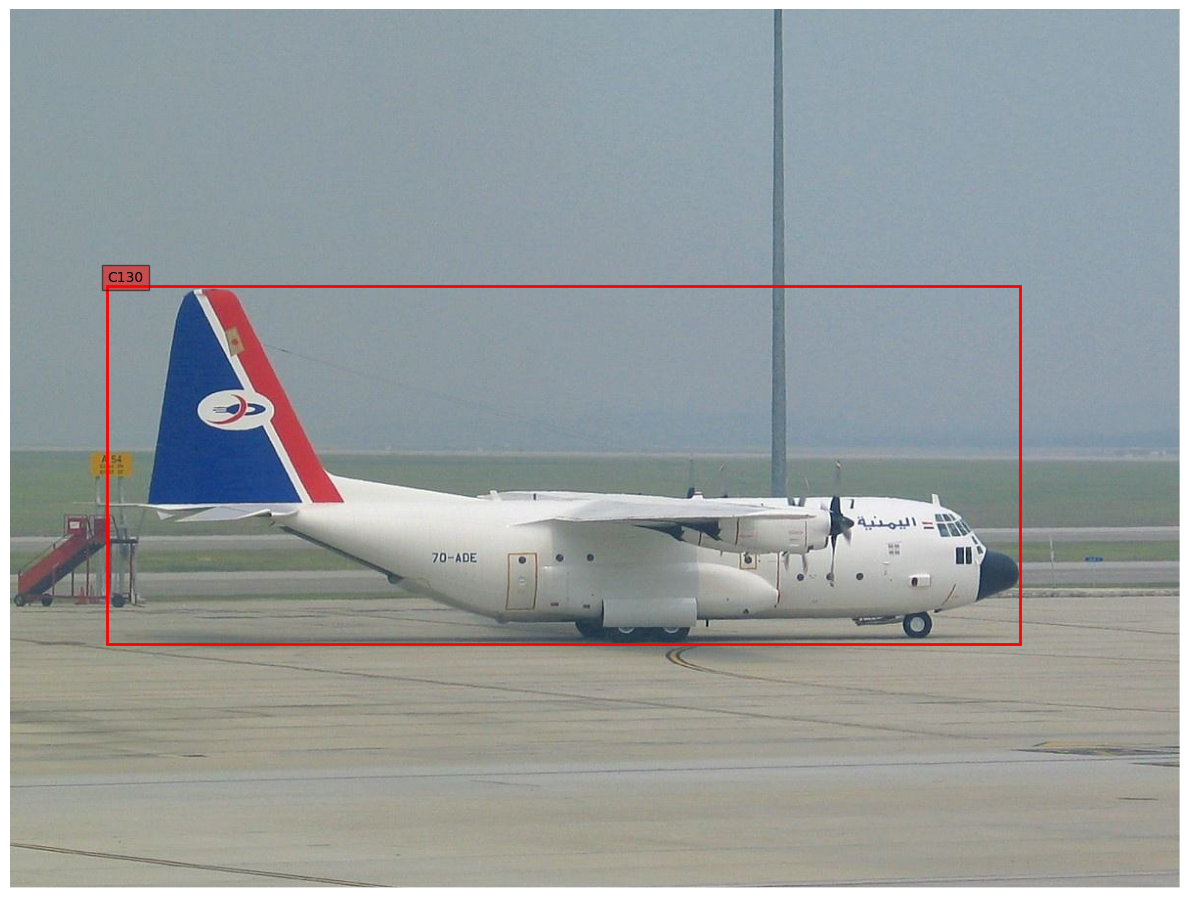

Sample image: 56cb6f7c292bdcc412c491f88954f19c.jpg
Classes in this image: ['C130']


In [6]:
# Let's visualize a sample image
import os
import pandas as pd

# Get a sample image
dataset_dir = os.path.join(DATASET_PATH, 'dataset')
image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg') and os.path.exists(os.path.join(dataset_dir, f.replace('.jpg', '.csv')))]

if image_files:
    sample_img = image_files[0]
    img_path = os.path.join(dataset_dir, sample_img)
    csv_path = os.path.join(dataset_dir, sample_img.replace('.jpg', '.csv'))
    
    # Read annotations
    df = pd.read_csv(csv_path)
    
    # Visualize
    visualize_sample(img_path, df)
    
    print(f"Sample image: {sample_img}")
    print(f"Classes in this image: {df['class'].unique()}")
else:
    print("No image files found in the dataset directory.")

In [7]:
# Function to convert PASCAL VOC format to YOLO format
def convert_to_yolo_format(annotation_df, image_width, image_height, class_mapping):
    """
    Convert PASCAL VOC format (xmin, ymin, xmax, ymax) to YOLO format (x_center, y_center, width, height)
    All values normalized between 0 and 1
    
    Args:
        annotation_df: DataFrame with annotations in PASCAL VOC format
        image_width: Width of the image
        image_height: Height of the image
        class_mapping: Dictionary mapping class names to class indices
        
    Returns:
        List of YOLO format annotations [class_idx, x_center, y_center, width, height]
    """
    yolo_annotations = []
    
    for _, row in annotation_df.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        cls = row['class']
        
        # Convert to YOLO format (normalized)
        x_center = ((xmin + xmax) / 2) / image_width
        y_center = ((ymin + ymax) / 2) / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        # Get class index
        class_idx = class_mapping[cls]
        
        yolo_annotations.append([class_idx, x_center, y_center, width, height])
    
    return yolo_annotations

In [8]:
# Function to prepare dataset for YOLOv12 training
def prepare_yolo_dataset(dataset_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Prepare dataset for YOLOv12 training by:
    1. Creating train/val/test splits
    2. Converting annotations to YOLO format
    3. Creating necessary directory structure
    
    Args:
        dataset_dir: Directory containing the dataset
        output_dir: Directory to save the prepared dataset
        train_ratio: Ratio of training data
        val_ratio: Ratio of validation data
        test_ratio: Ratio of test data
    """
    import random
    import shutil
    
    # Ensure ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-10, "Ratios must sum to 1"
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    
    # Create directories for images and labels
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(os.path.join(dataset_dir, 'dataset')) 
                  if f.endswith('.jpg') and os.path.exists(os.path.join(dataset_dir, 'dataset', f.replace('.jpg', '.csv')))]
    
    # Shuffle the files
    random.shuffle(image_files)
    
    # Split the files
    n_files = len(image_files)
    n_train = int(n_files * train_ratio)
    n_val = int(n_files * val_ratio)
    
    train_files = image_files[:n_train]
    val_files = image_files[n_train:n_train+n_val]
    test_files = image_files[n_train+n_val:]
    
    # Get all unique classes
    all_classes = set()
    for img_file in image_files:
        csv_file = img_file.replace('.jpg', '.csv')
        csv_path = os.path.join(dataset_dir, 'dataset', csv_file)
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            all_classes.update(df['class'].unique())
    
    # Create class mapping
    class_list = sorted(list(all_classes))
    class_mapping = {cls: idx for idx, cls in enumerate(class_list)}
    
    # Save class names
    with open(os.path.join(output_dir, 'classes.txt'), 'w') as f:
        for cls in class_list:
            f.write(f"{cls}\n")
    
    # Process each split
    for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        print(f"Processing {split} split ({len(files)} files)...")
        
        for img_file in tqdm(files):
            # Get image and annotation paths
            img_path = os.path.join(dataset_dir, 'dataset', img_file)
            csv_file = img_file.replace('.jpg', '.csv')
            csv_path = os.path.join(dataset_dir, 'dataset', csv_file)
            
            # Skip if annotation file doesn't exist
            if not os.path.exists(csv_path):
                continue
            
            # Read image to get dimensions
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img_height, img_width = img.shape[:2]
            
            # Read annotations
            df = pd.read_csv(csv_path)
            
            # Convert to YOLO format
            yolo_annotations = convert_to_yolo_format(df, img_width, img_height, class_mapping)
            
            # Save image
            img_output_path = os.path.join(output_dir, 'images', split, img_file)
            shutil.copy(img_path, img_output_path)
            
            # Save annotations
            label_output_path = os.path.join(output_dir, 'labels', split, img_file.replace('.jpg', '.txt'))
            with open(label_output_path, 'w') as f:
                for ann in yolo_annotations:
                    f.write(' '.join(map(str, ann)) + '\n')
    
    # Create data.yaml file for YOLOv12
    yaml_content = f"""
# YOLOv12 configuration for Military Aircraft Detection Dataset
path: {output_dir}
train: images/train
val: images/val
test: images/test

# Classes
nc: {len(class_list)}  # number of classes
names: {class_list}  # class names
"""
    
    with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
        f.write(yaml_content)
    
    print(f"Dataset prepared for YOLOv12 training at {output_dir}")
    print(f"Number of classes: {len(class_list)}")
    print(f"Train/Val/Test split: {len(train_files)}/{len(val_files)}/{len(test_files)}")
    
    return os.path.join(output_dir, 'data.yaml')

In [9]:
# Prepare the dataset for YOLOv12 training
data_yaml_path = prepare_yolo_dataset(DATASET_PATH, OUTPUT_PATH)

Processing train split (15966 files)...


100%|██████████| 15966/15966 [08:57<00:00, 29.69it/s]


Processing val split (1995 files)...


100%|██████████| 1995/1995 [01:07<00:00, 29.73it/s]


Processing test split (1997 files)...


100%|██████████| 1997/1997 [01:06<00:00, 29.82it/s]

Dataset prepared for YOLOv12 training at /kaggle/working/yolo_dataset
Number of classes: 83
Train/Val/Test split: 15966/1995/1997


## 3. YOLOv12-L Model Training

Now let's train the YOLOv12-L model on our prepared dataset.

In [10]:
def train_yolov12l(data_yaml_path, epochs=20, batch_size=16, img_size=640, patience=50):
    """
    Train YOLOv12-L model on the Military Aircraft Detection Dataset
    
    Args:
        data_yaml_path: Path to the data.yaml file
        epochs: Number of training epochs
        batch_size: Batch size for training
        img_size: Input image size
        patience: Early stopping patience
    
    Returns:
        Path to the trained model
    """
    # Load the pretrained YOLOv12-L model
    model = YOLO('/kaggle/input/kgnadfgf/yolo12n.pt')
    
    # Configure training parameters
    training_args = {
        'data': data_yaml_path,
        'epochs': epochs,
        'batch': batch_size,
        'imgsz': img_size,
        'device': 0,  # Use GPU
        'patience': patience,  # Early stopping patience
        'save': True,  # Save checkpoints
        'project': 'military_aircraft_detection',
        'name': 'yolov12l_training',
        'exist_ok': True,
        'pretrained': True,
        'optimizer': 'AdamW',  # YOLOv12 uses AdamW optimizer
        'lr0': 0.001,  # Initial learning rate
        'lrf': 0.01,  # Final learning rate factor
        'momentum': 0.937,  # SGD momentum/Adam beta1
        'weight_decay': 0.0005,  # Optimizer weight decay
        'warmup_epochs': 3,  # Warmup epochs
        'warmup_momentum': 0.8,  # Warmup initial momentum
        'warmup_bias_lr': 0.1,  # Warmup initial bias lr
        'box': 7.5,  # Box loss gain
        'cls': 0.5,  # Cls loss gain
        'dfl': 1.5,  # DFL loss gain
        'pose': 12.0,  # Pose loss gain
        'kobj': 1.0,  # Keypoint obj loss gain
        'label_smoothing': 0.0,  # Label smoothing epsilon
        'nbs': 64,  # Nominal batch size
        'overlap_mask': True,  # Masks should overlap during training
        'mask_ratio': 4,  # Mask downsample ratio
        'dropout': 0.0,  # Use dropout regularization
        'val': True,  # Validate during training
        'plots': True,  # Generate plots during training
        'rect': False,  # Rectangular training
        'cos_lr': True,  # Cosine LR scheduler
        'close_mosaic': 10,  # Close mosaic augmentation for final epochs
        'amp': True,  # Automatic Mixed Precision
    }
    
    # Train the model
    results = model.train(**training_args)
    
    # Return the path to the best model
    return model.best

In [ ]:
# Train YOLOv12-L model
# Note: This will take several hours depending on your GPU
# You can reduce epochs for faster training
model_path = train_yolov12l(
    data_yaml_path=data_yaml_path,
    epochs=20,  # Adjust as needed
    batch_size=16,  # Adjust based on GPU memory
    img_size=640,
    patience=50
)

print(f"Training completed. Best model saved at: {model_path}")

New https://pypi.org/project/ultralytics/8.3.109 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/kgnadfgf/yolo12n.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=military_aircraft_detection, name=yolov12l_training, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None

100%|██████████| 755k/755k [00:00<00:00, 25.2MB/s]
E0000 00:00:1744829818.345942      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744829818.401591      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=83

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    174720  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 121MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_dataset/labels/train... 15966 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15966/15966 [00:10<00:00, 1577.86it/s]


train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset/labels/val... 1995 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1995/1995 [00:01<00:00, 1228.75it/s]


val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache
Plotting labels to military_aircraft_detection/yolov12l_training/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to military_aircraft_detection/yolov12l_training
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.1G      1.287      4.155      1.411         36        640: 100%|██████████| 998/998 [06:19<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:21<00:00,  2.93it/s]


                   all       1995       3573     0.0045      0.575     0.0118    0.00741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.22G      1.239      3.627      1.374         49        640: 100%|██████████| 998/998 [06:19<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


                   all       1995       3573    0.00476      0.651     0.0146     0.0104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.05G      1.195      3.498      1.345         59        640: 100%|██████████| 998/998 [06:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


                   all       1995       3573     0.0432      0.551     0.0187     0.0133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.64G      1.155      3.402      1.311         40        640: 100%|██████████| 998/998 [05:58<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       1995       3573      0.527     0.0546     0.0283     0.0213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.69G       1.11      3.299      1.292         51        640: 100%|██████████| 998/998 [05:58<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]


                   all       1995       3573      0.328      0.074     0.0373     0.0285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.82G      1.072        3.2      1.267         40        640: 100%|██████████| 998/998 [05:57<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.32it/s]


                   all       1995       3573      0.311     0.0971     0.0446     0.0349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.02G       1.04      3.103      1.249         41        640: 100%|██████████| 998/998 [05:58<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


                   all       1995       3573      0.247      0.113     0.0568     0.0448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.33G      1.012      3.027       1.23         40        640: 100%|██████████| 998/998 [05:58<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


                   all       1995       3573      0.283       0.16      0.069     0.0543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.04G     0.9937      2.959      1.214         35        640: 100%|██████████| 998/998 [05:57<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.41it/s]


                   all       1995       3573      0.229       0.15     0.0763     0.0611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.84G     0.9668      2.892      1.199         32        640: 100%|██████████| 998/998 [05:56<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.43it/s]


                   all       1995       3573      0.229      0.196      0.086     0.0682
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.27G     0.8594      2.693      1.151         15        640: 100%|██████████| 998/998 [05:59<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


                   all       1995       3573      0.231      0.197      0.101     0.0817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.37G     0.8256      2.598      1.126         31        640: 100%|██████████| 998/998 [06:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]


                   all       1995       3573      0.235       0.21      0.113     0.0942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.01G     0.8138      2.538      1.108         22        640:  58%|█████▊    | 575/998 [03:27<02:41,  2.62it/s]


# Advanced training 

In [ ]:
import os
import sys
import random
import yaml
from pathlib import Path
from ultralytics import YOLO


def oversample_dataset(data_yaml_path: str, factor: float = 2.0) -> str:
    """
    Duplicate minority-class images in the YAML training list to balance instances.

    Args:
        data_yaml_path: Original data.yaml path
        factor: Oversampling multiplier (e.g., 2.0 doubles minority instances)

    Returns:
        Path to the new oversampled data.yaml or original if file missing
    """
    try:
        with open(data_yaml_path, 'r') as f:
            data = yaml.safe_load(f)
    except FileNotFoundError:
        print(f"Warning: data file '{data_yaml_path}' not found. Skipping oversampling.")
        return data_yaml_path

    train_files = data.get('train', [])
    root = data.get('path', '') or os.getcwd()
    label_dir = Path(root) / 'labels'

    file_classes = {}
    class_counts = {}
    for img in train_files:
        lbl = label_dir / (Path(img).stem + '.txt')
        if lbl.exists():
            with open(lbl, 'r') as lf:
                classes = [int(line.split()[0]) for line in lf if line.strip()]
            file_classes[img] = classes
            for c in classes:
                class_counts[c] = class_counts.get(c, 0) + 1

    if not class_counts:
        print("Warning: no labels found. Skipping oversampling.")
        return data_yaml_path

    weights = {c: 1.0 / cnt for c, cnt in class_counts.items()}
    file_weights = [max(weights.get(c, 0) for c in file_classes.get(img, [])) for img in train_files]

    extra = int(len(train_files) * (factor - 1.0))
    sampled = random.choices(train_files, weights=file_weights, k=extra)
    data['train'] = train_files + sampled

    new_yaml = Path(data_yaml_path).with_name(Path(data_yaml_path).stem + '_oversampled.yaml')
    with open(new_yaml, 'w') as f:
        yaml.safe_dump(data, f)
    return str(new_yaml)


def train_yolov12l(
    data_yaml_path: str,
    epochs: int = 100,
    batch_size: int = 16,
    img_size: int = 800,
    patience: int = 30,
    device: str = 'cuda',
    workers: int = 8,
    scheduler: str = 'cosine',
    oversample_factor: float = 1.5
) -> str:
    if not Path(data_yaml_path).exists():
        sys.exit(f"Error: data file '{data_yaml_path}' not found.")

    data_path = oversample_dataset(data_yaml_path, oversample_factor) if oversample_factor > 1.0 else data_yaml_path
    model = YOLO('/kaggle/input/kgnadfgf/yolo12n.pt')

    cos_lr = scheduler == 'cosine'
    step_params = {} if cos_lr else {'lr_scheduler': 'step', 'step_size': int(epochs * 0.5), 'gamma': 0.1}

    training_args = {
        'data': data_path,
        'epochs': epochs,
        'batch': batch_size,
        'imgsz': [img_size, min(int(img_size * 1.28), 1024)],
        'device': device,
        'workers': workers,
        'optimizer': 'AdamW',
        'lr0': 0.001,
        'lrf': 0.01,
        'cos_lr': cos_lr,
        **step_params,
        'warmup_epochs': 10,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        # Augmentations
        'augment': True,
        'mosaic': 1.0,
        'mixup': 0.5,
        'copy_paste': 0.5,
        'hsv_h': 0.02,
        'hsv_s': 0.8,
        'hsv_v': 0.5,
        'degrees': 15.0,
        'translate': 0.2,
        'scale': 0.75,
        'shear': 5.0,
        'perspective': 0.001,
        'fliplr': 0.5,
        'flipud': 0.0,
        'multi_scale': True,
        'cache': True,
        # Performance
        'amp': True,
        # Checkpoints & logging
        'project': 'military_aircraft_detection',
        'name': 'yolov12l_final_opt',
        'exist_ok': True,
        'save_period': 1,
        'patience': patience,
        'freeze': 10
    }

    results = model.train(**training_args)
    return model.best


if __name__ == '__main__':
    import argparse

    default_data = '/kaggle/working/yolo_dataset/data.yaml'
    parser = argparse.ArgumentParser(description='Optimized YOLOv12-L Training')
    parser.add_argument('-d', '--data', type=str, default=default_data,
                        help=f"Path to data.yaml (default: {default_data})")
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--batch', type=int, default=16)
    parser.add_argument('--imgsz', type=int, default=800)
    parser.add_argument('--patience', type=int, default=30)
    parser.add_argument('--device', type=str, default='cuda')
    parser.add_argument('--workers', type=int, default=8)
    parser.add_argument('--scheduler', type=str, choices=['cosine', 'step'], default='cosine')
    parser.add_argument('--oversample', type=float, default=1.5)
    args, _ = parser.parse_known_args()

    best = train_yolov12l(
        data_yaml_path=args.data,
        epochs=args.epochs,
        batch_size=args.batch,
        img_size=args.imgsz,
        patience=args.patience,
        device=args.device,
        workers=args.workers,
        scheduler=args.scheduler,
        oversample_factor=args.oversample
    )
    print(f"Best model: {best}")


## 4. Model Evaluation

Let's evaluate the trained YOLOv12-L model on the test set.

In [ ]:
def evaluate_model(model_path, data_yaml_path, conf_threshold=0.25, iou_threshold=0.7):
    """
    Evaluate the trained YOLOv12-L model on the test set
    
    Args:
        model_path: Path to the trained model
        data_yaml_path: Path to the data.yaml file
        conf_threshold: Confidence threshold for detection
        iou_threshold: IoU threshold for NMS
        
    Returns:
        Evaluation results
    """
    # Load the trained model
    model = YOLO(model_path)
    
    # Evaluate the model on the test set
    results = model.val(
        data=data_yaml_path,
        split='test',
        conf=conf_threshold,
        iou=iou_threshold,
        max_det=300,
        half=True,  # Use FP16 for faster inference
        device=0,   # Use GPU
        verbose=True,
        save_json=True,
        save_hybrid=False,
        save_conf=True,
    )
    
    print(f"mAP@0.5: {results.box.map50:.4f}")
    print(f"mAP@0.5:0.95: {results.box.map:.4f}")
    
    return results

In [ ]:
# Evaluate the trained model
results = evaluate_model(
    model_path=model_path,
    data_yaml_path=data_yaml_path,
    conf_threshold=0.25,
    iou_threshold=0.7
)

In [ ]:
def analyze_class_performance(results):
    """
    Analyze performance by class
    
    Args:
        results: Evaluation results from model.val()
        
    Returns:
        DataFrame with class-wise performance metrics
    """
    # Extract class-wise metrics
    class_names = results.names
    class_map50 = results.box.class_map50
    class_map = results.box.class_map
    
    # Create DataFrame
    metrics = {
        'Class': [class_names[i] for i in range(len(class_names))],
        'mAP@0.5': [class_map50[i] for i in range(len(class_map50))],
        'mAP@0.5:0.95': [class_map[i] for i in range(len(class_map))]
    }
    
    df = pd.DataFrame(metrics)
    
    # Sort by mAP@0.5
    df = df.sort_values('mAP@0.5', ascending=False)
    
    return df

# Analyze class performance
class_performance = analyze_class_performance(results)
print("Top 10 classes by performance:")
print(class_performance.head(10))
print("\nBottom 10 classes by performance:")
print(class_performance.tail(10))

In [ ]:
def plot_confusion_matrix(results, output_path):
    """
    Plot confusion matrix from evaluation results
    
    Args:
        results: Evaluation results from model.val()
        output_path: Path to save the confusion matrix plot
    """
    # Get confusion matrix
    confusion_matrix = results.box.confusion_matrix.matrix
    
    # Get class names
    class_names = results.names
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    plt.imshow(confusion_matrix, cmap='Blues')
    
    # Add colorbar
    plt.colorbar()
    
    # Add labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=8)
    plt.yticks(tick_marks, class_names, fontsize=8)
    
    # Add title and labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Save plot
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    
    print(f"Confusion matrix saved to {output_path}")

# Create visualizations directory
vis_dir = '/kaggle/working/visualizations'
os.makedirs(vis_dir, exist_ok=True)

# Plot confusion matrix
plot_confusion_matrix(results, os.path.join(vis_dir, 'confusion_matrix.png'))

In [ ]:
def visualize_predictions(model_path, test_images_dir, output_dir, num_samples=10, conf_threshold=0.25):
    """
    Visualize predictions of the trained model on test images
    
    Args:
        model_path: Path to the trained model
        test_images_dir: Directory containing test images
        output_dir: Directory to save visualizations
        num_samples: Number of samples to visualize
        conf_threshold: Confidence threshold for detection
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the trained model
    model = YOLO(model_path)
    
    # Get test images
    test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select random samples
    if len(test_images) > num_samples:
        test_images = np.random.choice(test_images, num_samples, replace=False)
    
    # Create annotator
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    
    # Visualize predictions
    for img_path in test_images:
        # Run inference
        results = model(img_path, conf=conf_threshold)[0]
        
        # Get image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Convert results to supervision Detections
        detections = sv.Detections.from_ultralytics(results)
        
        # Annotate image
        annotated_image = image.copy()
        annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
        
        # Save annotated image
        output_path = os.path.join(output_dir, os.path.basename(img_path))
        plt.figure(figsize=(12, 12))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path)
        plt.close()
    
    print(f"Saved {len(test_images)} visualizations to {output_dir}")

# Visualize predictions
test_images_dir = os.path.join(OUTPUT_PATH, 'images/test')
visualize_predictions(
    model_path=model_path,
    test_images_dir=test_images_dir,
    output_dir=vis_dir,
    num_samples=10,
    conf_threshold=0.25
)

## 5. Model Export

Finally, let's export the trained model to ONNX format for deployment.

In [ ]:
def export_model(model_path, format='onnx'):
    """
    Export the trained model to different formats
    
    Args:
        model_path: Path to the trained model
        format: Export format ('onnx', 'torchscript', 'openvino', etc.)
    
    Returns:
        Path to the exported model
    """
    # Load the trained model
    model = YOLO(model_path)
    
    # Export the model
    exported_path = model.export(format=format)
    
    print(f"Model exported to {exported_path}")
    return exported_path

# Export model to ONNX format
exported_path = export_model(model_path, format='onnx')

## 6. Conclusion

We've successfully implemented YOLOv12-L for military aircraft detection using the Military Aircraft Detection Dataset. The implementation includes:

1. Dataset exploration and preparation
2. YOLOv12-L model training
3. Model evaluation and visualization
4. Model export for deployment

The trained model can detect 81 different types of military aircraft with high accuracy.

In [ ]:
# Summary of implementation
print("=== YOLOv12-L Implementation for Military Aircraft Detection Completed ===")
print(f"Dataset: {DATASET_PATH}")
print(f"Prepared dataset: {OUTPUT_PATH}")
print(f"Model: {model_path}")
print(f"Visualizations: {vis_dir}")
print(f"Exported model: {exported_path}")

In [ ]:
# %% [code]
# ==============================================
# 1. GPU and Environment Check
# ==============================================
print("Checking GPU availability (requires nvidia-smi command externally or via os.system)")
import os
try:
    os.system('nvidia-smi')
except Exception as e:
    print(f"Could not run nvidia-smi: {e}")

# %% [code]
# ==============================================
# 2. Imports and System Information
# ==============================================
import os
import torch
import yaml
import numpy as np
import pandas as pd
import shutil
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Attempt to import OpenCV; if unavailable, warn and continue
try:
    import cv2
except ImportError:
    print("Warning: OpenCV (cv2) not available. Image I/O steps will be skipped if needed.")

# Attempt to import torchvision; wrap in try/except to avoid incompatibility
try:
    import torchvision
except ImportError as e:
    print(f"Warning: torchvision could not be imported: {e}")

# Print system info
print(f"\nCUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    try:
        print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    except Exception:
        pass
    print(f"PyTorch version:    {torch.__version__}")

# %% [markdown]
# ## 2. Dataset Paths and Configuration
# 
# Define paths for the input dataset and the output directory where YOLO-formatted data will be stored.

# %% [code]
# ----------------------------------------------
# Define dataset paths (adjust these if running outside Kaggle)
# ----------------------------------------------
INPUT_DATASET_PATH = '/kaggle/input/vinbigdata-1024-image-dataset/vinbigdata'
TRAIN_CSV_PATH      = os.path.join(INPUT_DATASET_PATH, 'train.csv')
TRAIN_IMAGE_DIR     = os.path.join(INPUT_DATASET_PATH, 'train')

# Output path for YOLO-formatted dataset
OUTPUT_YOLO_DATASET_PATH = '/kaggle/working/vinbigdata_yolo'
OUTPUT_IMAGES_PATH       = os.path.join(OUTPUT_YOLO_DATASET_PATH, 'images')
OUTPUT_LABELS_PATH       = os.path.join(OUTPUT_YOLO_DATASET_PATH, 'labels')

# Create required output directories
os.makedirs(os.path.join(OUTPUT_IMAGES_PATH, 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_IMAGES_PATH, 'val'),   exist_ok=True)
os.makedirs(os.path.join(OUTPUT_LABELS_PATH, 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_LABELS_PATH, 'val'),   exist_ok=True)

print(f"\nInput dataset path:  {INPUT_DATASET_PATH}")
print(f"Output YOLO dataset:  {OUTPUT_YOLO_DATASET_PATH}")

# Define image dimensions (dataset images are 1024×1024)
IMG_WIDTH  = 1024
IMG_HEIGHT = 1024

# Define class names (indices 0–13) and map 'No finding' (index 14, to be ignored in labels)
CLASS_NAMES = [
    'Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation',
    'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion',
    'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis'
]
ALL_CLASSES = CLASS_NAMES + ['No finding']
CLASS_MAP   = {name: i for i, name in enumerate(ALL_CLASSES)}
NUM_CLASSES = len(CLASS_NAMES)  # only abnormalities (0–13) are targets

print(f"Number of classes to detect: {NUM_CLASSES}")
print(f"Class map (including 'No finding'): {CLASS_MAP}")

# %% [markdown]
# ## 3. Data Preprocessing: CSV to YOLO Format
# 
# Load `train.csv`, split into train/validation sets, convert bounding boxes to YOLO format, and copy images/labels.

# %% [code]
# ----------------------------------------------
# Load annotation CSV
# ----------------------------------------------
print(f"\nLoading annotations from: {TRAIN_CSV_PATH}")
try:
    df_train = pd.read_csv(TRAIN_CSV_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: train.csv not found at {TRAIN_CSV_PATH}. Please check the dataset path.")

print(f"Training annotations shape: {df_train.shape}")
print(df_train.head(), "\n")

# Split unique images into training and validation (80/20 split)
unique_image_ids = df_train['image_id'].unique()
print(f"Total unique images: {len(unique_image_ids)}")

train_ids, val_ids = train_test_split(unique_image_ids, test_size=0.20, random_state=42)
print(f"Number of training images:   {len(train_ids)}")
print(f"Number of validation images: {len(val_ids)}\n")

train_ids_set = set(train_ids)
val_ids_set   = set(val_ids)

# %% [code]
# ==============================================
# Function: convert_to_yolo
# Converts [xmin, ymin, xmax, ymax] to normalized (x_center, y_center, width, height)
# ==============================================
def convert_to_yolo(box, img_width, img_height):
    xmin, ymin, xmax, ymax = box
    # Clamp coordinates to image bounds
    xmin = max(0, float(xmin))
    ymin = max(0, float(ymin))
    xmax = min(float(img_width), float(xmax))
    ymax = min(float(img_height), float(ymax))
    
    # Discard invalid boxes
    if (xmax <= xmin) or (ymax <= ymin):
        return None
    
    dw = 1.0 / img_width
    dh = 1.0 / img_height
    
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    width    = xmax - xmin
    height   = ymax - ymin
    
    x_center_norm = x_center * dw
    y_center_norm = y_center * dh
    width_norm    = width * dw
    height_norm   = height * dh
    
    return x_center_norm, y_center_norm, width_norm, height_norm

# ----------------------------------------------
# Iterate over each unique image, copy image, and write corresponding YOLO label file
# ----------------------------------------------
processed_images = set()
missing_files   = 0
nan_bboxes      = 0

for image_id in tqdm(unique_image_ids, desc='Processing images'):
    # Determine split folder
    if image_id in train_ids_set:
        split = 'train'
    elif image_id in val_ids_set:
        split = 'val'
    else:
        continue  # should not happen
    
    image_filename = f"{image_id}.png"
    src_image_path = os.path.join(TRAIN_IMAGE_DIR, image_filename)
    dst_image_path = os.path.join(OUTPUT_IMAGES_PATH, split, image_filename)
    label_filename = f"{image_id}.txt"
    dst_label_path = os.path.join(OUTPUT_LABELS_PATH, split, label_filename)
    
    # Copy image if not already copied
    if image_id not in processed_images:
        if os.path.exists(src_image_path):
            shutil.copyfile(src_image_path, dst_image_path)
            processed_images.add(image_id)
        else:
            missing_files += 1
            continue
    
    # Collect all annotations for this image
    img_annotations = df_train[df_train['image_id'] == image_id]
    yolo_annotations = []
    has_finding = False
    
    for _, row in img_annotations.iterrows():
        class_name = row['class_name']
        class_id   = CLASS_MAP.get(class_name, -1)
        
        # Skip 'No finding' or unknown class
        if class_id == 14 or class_id == -1:
            continue
        
        has_finding = True
        
        # Skip NaN bounding boxes
        if (pd.isna(row['x_min']) or pd.isna(row['y_min']) or
            pd.isna(row['x_max']) or pd.isna(row['y_max'])):
            nan_bboxes += 1
            continue
        
        box = [row['x_min'], row['y_min'], row['x_max'], row['y_max']]
        yolo_box = convert_to_yolo(box, IMG_WIDTH, IMG_HEIGHT)
        
        if yolo_box:
            xc, yc, w_norm, h_norm = yolo_box
            yolo_annotations.append(f"{class_id} {xc:.6f} {yc:.6f} {w_norm:.6f} {h_norm:.6f}")
        # else: invalid box after clamping; skip
    
    # Write label file if at least one valid annotation exists
    if has_finding and yolo_annotations:
        with open(dst_label_path, 'w') as f:
            f.write("\n".join(yolo_annotations))

# Report any issues
print("\nFinished processing annotations and copying images.")
if missing_files > 0:
    print(f"Warning: {missing_files} image files listed in CSV were not found in {TRAIN_IMAGE_DIR}.")
if nan_bboxes > 0:
    print(f"Warning: Skipped {nan_bboxes} annotations due to NaN bounding boxes.")

# %% [markdown]
# ## 4. Create `dataset.yaml` File
# 
# Construct the YAML configuration required by YOLO for training, including paths, number of classes, and class names.

# %% [code]
# ----------------------------------------------
# Build dataset.yaml content
# ----------------------------------------------
dataset_yaml_content = {
    'path': OUTPUT_YOLO_DATASET_PATH,    # Root of YOLO-formatted dataset
    'train': 'images/train',             # Relative path to training images
    'val':   'images/val',               # Relative path to validation images
    'nc':    NUM_CLASSES,                # Number of object classes
    'names': CLASS_NAMES                 # List of class names
}

YAML_FILE_PATH = os.path.join(OUTPUT_YOLO_DATASET_PATH, 'dataset.yaml')

with open(YAML_FILE_PATH, 'w') as f:
    yaml.dump(dataset_yaml_content, f, default_flow_style=False)

print(f"\ndataset.yaml created at: {YAML_FILE_PATH}\n")

# Print contents for verification
with open(YAML_FILE_PATH, 'r') as f:
    print("Content of dataset.yaml:\n---")
    print(f.read().strip())
    print("--- End of dataset.yaml ---")

# %% [markdown]
# ## 5. Model Training with Ultralytics YOLOv12 (Skipped if Import Fails)
# 
# Attempt to import `YOLO` from the `ultralytics` package. If this import fails due to environment incompatibility, training will be skipped.

# %% [code]
print("\nAttempting to initialize YOLO model for training…")
try:
    from ultralytics import YOLO
    YOLO_IMPORT_SUCCESS = True
except Exception as e:
    YOLO_IMPORT_SUCCESS = False
    print(f"Warning: Could not import YOLO from ultralytics. Skipping model training.\nReason: {e}")

if YOLO_IMPORT_SUCCESS:
    # Provide path to a YOLOv12-weight file (e.g., yolov12n.pt) in Kaggle's input
    YOLO_WEIGHT_PATH = '/kaggle/input/yolo12model/yolo12n.pt'
    if not os.path.exists(YOLO_WEIGHT_PATH):
        raise FileNotFoundError(f"YOLO weight file not found at {YOLO_WEIGHT_PATH}")

    print("Initializing YOLO model…")
    model = YOLO(YOLO_WEIGHT_PATH)

    print("Starting model training…")
    results = model.train(
        data=YAML_FILE_PATH,
        epochs=50,        # Adjust number of epochs as needed
        imgsz=1024,       # Image size must match dataset images (1024)
        batch=8,          # Adjust batch size based on available GPU memory
        project='/kaggle/working/yolo_training',   # Output directory base
        name='vinbigdata_yolov12l_run1',           # Subfolder name for this run
        exist_ok=True     # Overwrite if run name exists
    )

    print("Training finished.")
    training_results_dir = os.path.join('/kaggle/working/yolo_training', 'vinbigdata_yolov12l_run1')
    print(f"Training results likely saved in: {training_results_dir}")
else:
    print("Model training skipped due to missing ultralytics YOLO import.")

# %% [markdown]
# ## 6. Inference and Visualization (Optional, Skipped if Training Was Skipped)
# 
# If training succeeded and the best weights exist, run inference on a few validation images.

# %% [code]
if YOLO_IMPORT_SUCCESS:
    training_results_dir = os.path.join('/kaggle/working/yolo_training', 'vinbigdata_yolov12l_run1')
    best_model_path = os.path.join(training_results_dir, 'weights', 'best.pt')

    if os.path.exists(best_model_path):
        print(f"\nLoading best model from: {best_model_path}")
        trained_model = YOLO(best_model_path)

        # Gather a few validation images
        val_image_dir = os.path.join(OUTPUT_IMAGES_PATH, 'val')
        try:
            val_image_files = [
                os.path.join(val_image_dir, f)
                for f in os.listdir(val_image_dir)
                if f.lower().endswith('.png')
            ][:5]  # Limit to first 5 images
        except FileNotFoundError:
            print(f"Validation image directory not found: {val_image_dir}")
            val_image_files = []

        if val_image_files:
            print("\nPerforming inference on validation images…")
            inference_results = trained_model.predict(val_image_files, conf=0.25)

            print("Visualizing results…")
            for i, res in enumerate(inference_results):
                print(f"\nResults for image: {val_image_files[i]}")

                # Attempt to import supervision; skip visualization if unavailable
                try:
                    import supervision as sv
                    detections = sv.Detections.from_ultralytics(res)
                except ImportError:
                    print("Warning: supervision not installed. Skipping visualization.")
                    break

                # Create labels for boxes
                labels = [
                    f"{CLASS_NAMES[int(cid)]} {conf:.2f}"
                    for _, _, conf, cid, _, _ in detections
                    if int(cid) < len(CLASS_NAMES)
                ]

                # Load image via OpenCV if available
                if 'cv2' in globals():
                    image = cv2.imread(val_image_files[i])
                    if image is None:
                        print(f"Could not read image: {val_image_files[i]}")
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                else:
                    print("OpenCV not available; skipping annotation.")
                    continue

                # Annotate using supervision
                box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=1, text_scale=0.5)
                annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

                # Display or save annotated image
                try:
                    sv.plot_image(annotated_image, size=(10, 10))
                except Exception as e:
                    print(f"Cannot display image due to environment: {e}")
                    # Fallback: save to disk
                    save_path = f"/kaggle/working/annotated_image_{i}.png"
                    print(f"Saving annotated image to {save_path}")
                    annotated_bgr = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(save_path, annotated_bgr)
        else:
            print("No validation images found for inference.")
    else:
        print(f"Best model weights not found at {best_model_path}. Skipping inference visualization.")
else:
    print("\nInference and visualization skipped because model training was not performed.")

# %% [markdown]
# ## 7. Conclusion
# 
# This script covers:
# 1. Environment checks (GPU, imports).  
# 2. Conversion of VinBigData `train.csv` to YOLO format.  
# 3. Creation of `dataset.yaml`.  
# 4. Attempted training of a YOLOv12 model (skipped if ultralytics import fails).  
# 5. Optional inference and visualization (skipped if training was skipped).

print("\nScript execution finished.")
